# NGBoost

En este notebook se entrena un modelo de juguete usando la librería NGBoost, y luego se grafican los resultados

In [162]:
import pandas as pd
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE
from ngboost.distns import Normal
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
import random

import seaborn as sns
sns.set()

In [2]:
def load_data(path=None):
    assert path != None, "no data path"
    data = pd.read_csv(path)
    data = pd.get_dummies(data)
    train, test = train_test_split(data, test_size=0.2)
    return train, test

In [3]:
train, test = load_data("winequality-red.csv")

In [4]:
train.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1282            7.9             0.765         0.00             2.0      0.084   
1536            6.1             0.530         0.08             1.9      0.077   
769             7.9             0.720         0.01             1.9      0.076   
127             8.1             1.330         0.00             1.8      0.082   
614             9.2             0.755         0.18             2.2      0.148   

      free sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
1282                  9.0                  22.0  0.99619  3.33       0.68   
1536                 24.0                  45.0  0.99528  3.60       0.68   
769                   7.0                  32.0  0.99668  3.39       0.54   
127                   3.0                  12.0  0.99640  3.54       0.48   
614                  10.0                 103.0  0.99690  2.87       1.36   

      alcohol  quality  
1282     10.9        6  
1536     10.3        6  
769       9.6        5  
127      10.9        5  
614      10.2        6

In [5]:
target = "quality"
train_cols = [x for x in train.columns if x != target]

In [6]:
X_train = train[train_cols]
Y_train = train[target]
X_test = test[train_cols]
Y_test = test[target]

### Para problemas de clasificación:
Dist = Bernoulli
### Para problemas de regresión:
Dist = Normal
### Para problemas de survival:
Dist = LogNormal

In [141]:
ngb = NGBoost(Base=default_tree_learner,
              Dist=Normal,
              Score=MLE(),
              natural_gradient=True,
              verbose=False,
              n_estimators=1000)
ngboost = ngb.fit(X_train,Y_train)

In [142]:
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

In [144]:
Y_preds[:5]

[5.827013639974971,
 5.257814921197369,
 5.932591020115582,
 5.170927891605774,
 6.187931239020452]

In [149]:
Y_dists.scale[:5]

array([0.44938203, 0.46056482, 0.48448858, 0.21700783, 0.3633743 ])

In [150]:
res_ngb = pd.DataFrame(columns=['mean', 'std'])
res_ngb['mean'] = Y_preds
res_ngb['std'] = Y_dists.scale
res_ngb['real'] = test.quality.values

In [151]:
res_ngb.sort_values(by='real', inplace=True)
res_ngb.reset_index(inplace=True, drop=True)
res_ngb.reset_index(inplace=True)

res_ngb['upper'] = res_ngb['mean'] + res_ngb['std']
res_ngb['lower'] = res_ngb['mean'] - res_ngb['std']

res_ngb.head()

index      mean       std  real     upper     lower
0      0  5.352833  0.469809     3  5.822643  4.883024
1      1  4.717569  0.659988     3  5.377557  4.057582
2      2  4.352503  0.639829     3  4.992333  3.712674
3      3  5.333952  0.509635     3  5.843586  4.824317
4      4  4.986400  0.664396     3  5.650797  4.322004

#### Graficamos un 20% de los datos

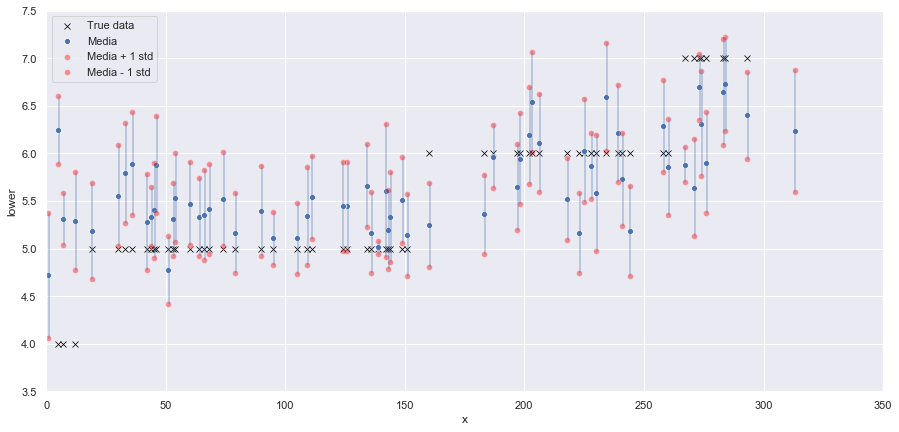

In [152]:
res_ngb_sample = res_ngb.sample(frac=0.2)
res_ngb_sample.columns = ['x', 'mean','std','real','upper','lower']

res_ngb_sample.sort_values(by='std', inplace=True)

plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="x", y="real",data=res_ngb_sample, marker='x', color='black', label='True data')
ax.set(xlim=(0, 350), ylim=(3.5, 7.5))
sns.scatterplot(x="x", y="mean",data=res_ngb_sample, ax=ax, label='Media')
sns.scatterplot(x="x", y="upper",data=res_ngb_sample, ax=ax, alpha=0.4, color='red',  label='Media + 1 std')
sns.scatterplot(x="x", y="lower",data=res_ngb_sample, ax=ax, alpha=0.4, color='red',  label='Media - 1 std')

for idx in np.arange(0,res_ngb_sample.shape[0]):
    # hay que re-escalar el eje Y, ya que axvline va de 0 a 1, siendo el margen inferior/superior respect. del eje y
    plt.axvline(res_ngb_sample.iloc[idx].x +0.35, (res_ngb_sample.iloc[idx].lower - 3.5)/4 ,(res_ngb_sample.iloc[idx].upper - 3.5)/4, alpha=0.4)
plt.legend()

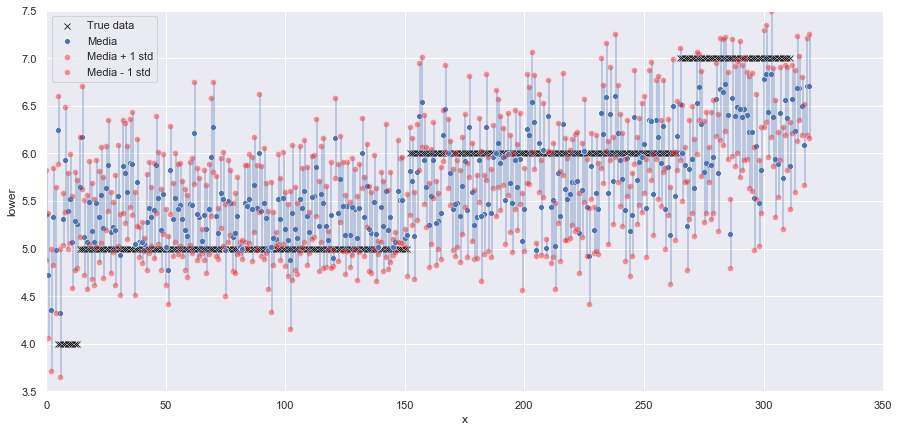

In [161]:
res_ngb_sample = res_ngb.copy()
res_ngb_sample.columns = ['x', 'mean','std','real','upper','lower']

res_ngb_sample.sort_values(by='std', inplace=True)

plt.figure(figsize=(15,7))
ax = sns.scatterplot(x="x", y="real",data=res_ngb_sample, marker='x', color='black', label='True data')
ax.set(xlim=(0, 350), ylim=(3.5, 7.5))
sns.scatterplot(x="x", y="mean",data=res_ngb_sample, ax=ax, label='Media')
sns.scatterplot(x="x", y="upper",data=res_ngb_sample, ax=ax, alpha=0.4, color='red',  label='Media + 1 std')
sns.scatterplot(x="x", y="lower",data=res_ngb_sample, ax=ax, alpha=0.4, color='red',  label='Media - 1 std')

for idx in np.arange(0,res_ngb_sample.shape[0]):
    plt.axvline(res_ngb_sample.iloc[idx].x +0.35, (res_ngb_sample.iloc[idx].lower - 3.5)/4 ,(res_ngb_sample.iloc[idx].upper - 3.5)/4, alpha=0.4)
plt.legend()

## Qué porcentaje está fuera del rango?

In [164]:
res_ngb.head(2)

index      mean       std  real     upper     lower
0      0  5.352833  0.469809     3  5.822643  4.883024
1      1  4.717569  0.659988     3  5.377557  4.057582

In [160]:
((res_ngb.real > res_ngb.upper) | (res_ngb.real < res_ngb.lower)).mean()

0.471875

### Miramos predicciones locales

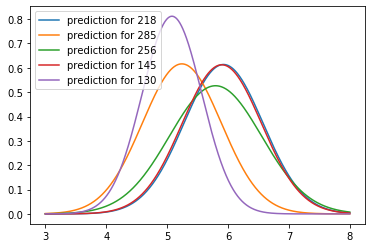

In [11]:
random_indexes = [random.randint(0, X_test.shape[0]) for x in range (0, 5)]

min_val = min(Y_train)
max_val = max(Y_train)

leg = []
for index in random_indexes:
    mu = Y_dists.loc[index]
    variance = Y_dists.scale[index]
    sigma = math.sqrt(variance)
    x = np.linspace(min_val, max_val, 1000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    leg.append("prediction for {0}".format(index))
plt.legend(leg)
plt.show()